<h1>MPST: Movie Plot Synopses with Tags</h1>

# 1. Business Problem

## 1.1 Description

Abstract Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

#### Problem Statement
- Identify which tag should be assigned to which movie.  
- we present the MPST corpus that contains plot synopses of 14,828 movies and their associations with a set of fine-grained tags, where each movie is tagged with one or more tags.

## 1.2 Sources

Dataset : https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

Please find the paper here: https://www.aclweb.org/anthology/L18-1274

This dataset was published in LREC 2018@Miyazaki, Japan.

Keywords Tag generation for movies, Movie plot analysis, Multi-label dataset, Narrative texts

More information is available here http://ritual.uh.edu/mpst-2018/

## 1.3 Real world/Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. No strict latency concerns.

# 2. Machine Learning Probelm

## 2.1 Data

<p> 
- Data will be in a csv file<br>
- Train.csv contains 6 columns : imdb_id, title, plot_synopsis, tags, split, synopsis_source <br>
- Size of Train.csv - 28MB <br>
- Number of rows in Train.csv = 14,828
</p>

## 2.2 Mapping the real-world problem to a Machine Learning Problem

### 2.2.1 Type of Machine Learning Problem

It is a multi-label classification problem 
Multi-label Classification: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document.

### 2.2.2 Performance metric

'Micro f1 score': 
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.

# 3. Exploratory Data Analysis

## 3.1 Data Loading and Cleaning

In [58]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import pickle
import re
import os
import string
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, accuracy_score

In [2]:
raw_data = pd.read_csv('mpst_full_data.csv', delimiter=',')

In [3]:
raw_data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


#### Finding and removing duplicate entries

In [4]:
dup_removed = raw_data.drop_duplicates(['title','plot_synopsis','split'])

In [5]:
dup_removed.count()[0]

14486

In [6]:
null_columns=dup_removed.columns[dup_removed.isnull().any()]
print(dup_removed[dup_removed.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [7]:
tuple(dup_removed['split'].unique())

('train', 'test', 'val')

In [8]:
objects = tuple(dup_removed['split'].unique())
y_pos = np.arange(len(objects))
performance = [dup_removed[dup_removed['split'] == 'train'].count()[0],dup_removed[dup_removed['split'] == 'test'].count()[0],dup_removed[dup_removed['split'] == 'val'].count()[0]]

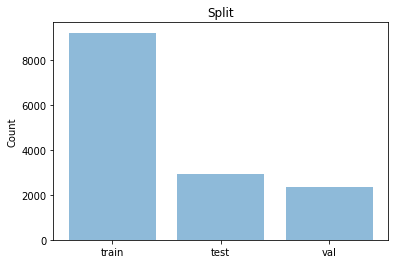

In [9]:
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Split')

plt.show()

## 3.2 Split into train, val and test

In [10]:
train = dup_removed[dup_removed['split'] == 'train']
train.count()[0]

9203

In [11]:
test = dup_removed[dup_removed['split'] == 'test']
test.count()[0]

2934

In [12]:
val = dup_removed[dup_removed['split'] == 'val']
val.count()[0]

2349

## 3.3 Analysis of Tags

In [13]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.replace(' ', '').split(','))
tag_vector = vectorizer.fit_transform(train['tags'])

In [14]:
print("Number of data points :", tag_vector.shape[0])
print("Number of unique tags :", tag_vector.shape[1])

Number of data points : 9203
Number of unique tags : 71


In [15]:
tags = vectorizer.get_feature_names()
print("Tags we have :", tags)

Tags we have : ['absurd', 'action', 'adultcomedy', 'allegory', 'alternatehistory', 'alternatereality', 'antiwar', 'atmospheric', 'autobiographical', 'avantgarde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christianfilm', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'goodversusevil', 'gothic', 'grindhousefilm', 'haunting', 'historical', 'historicalfiction', 'homemovie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magicalrealism', 'melodrama', 'murder', 'mystery', 'neonoir', 'nonfiction', 'paranormal', 'philosophical', 'plottwist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']


In [16]:
freqs = tag_vector.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [17]:
result

{'absurd': 166,
 'action': 397,
 'adultcomedy': 82,
 'allegory': 87,
 'alternatehistory': 63,
 'alternatereality': 126,
 'antiwar': 71,
 'atmospheric': 262,
 'autobiographical': 28,
 'avantgarde': 155,
 'blaxploitation': 56,
 'bleak': 139,
 'boring': 329,
 'brainwashing': 77,
 'christianfilm': 27,
 'claustrophobic': 52,
 'clever': 58,
 'comedy': 1178,
 'comic': 63,
 'cruelty': 276,
 'cult': 1650,
 'cute': 116,
 'dark': 252,
 'depressing': 124,
 'dramatic': 252,
 'entertaining': 445,
 'fantasy': 319,
 'feel-good': 48,
 'flashback': 1814,
 'goodversusevil': 535,
 'gothic': 279,
 'grindhousefilm': 44,
 'haunting': 94,
 'historical': 169,
 'historicalfiction': 93,
 'homemovie': 96,
 'horror': 301,
 'humor': 523,
 'insanity': 403,
 'inspiring': 67,
 'intrigue': 99,
 'magicalrealism': 34,
 'melodrama': 289,
 'murder': 3588,
 'mystery': 320,
 'neonoir': 451,
 'nonfiction': 22,
 'paranormal': 325,
 'philosophical': 152,
 'plottwist': 121,
 'pornographic': 101,
 'prank': 166,
 'psychedelic': 11

In [18]:
tag_quest_count = tag_vector.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]

In [19]:
print( "Maximum number of tags per movie: %d"%max(tag_quest_count))
print( "Minimum number of tags per movie: %d"%min(tag_quest_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per movie: 25
Minimum number of tags per movie: 1
Avg. number of tags per movie: 2.977181


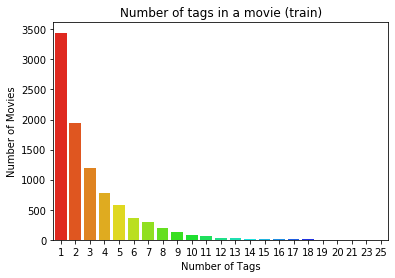

In [20]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in a movie (train)")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Movies")
plt.show()

### Most Frequent Tags

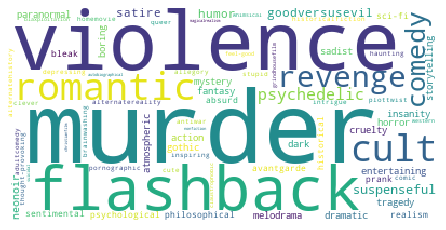

In [21]:
tup = dict(result.items())

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tup)

fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag_wordcloud.png")
plt.show()

## 3.4 Cleaning and preprocessing of Plot, Title and tags

In [22]:
train_set = train.drop(['split','synopsis_source','imdb_id'], axis=1)
test_set = test.drop(['split','synopsis_source','imdb_id'],axis=1)
val_set = val.drop(['split','synopsis_source','imdb_id'],axis=1)

In [23]:
train_set['tags'] = train_set['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))
test_set['tags'] = test_set['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))
val_set['tags'] = val_set['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))

In [24]:
train_set.head()

,title,plot_synopsis,tags
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,cult horror gothic murder atmospheric
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",inspiring romantic stupid feel-good
6,Baise-moi,Baise-moi tells the story of Nadine and Manu w...,gothic cruelty violence cult revenge sadist
7,Flightplan,Kyle Pratt (Jodie Foster) is a propulsion engi...,mystery suspenseful action murder flashback


In [25]:
from tqdm import tqdm
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
preprocessed_plot_train = []
# tqdm is for printing the status bar
for sentance in tqdm(train_set['plot_synopsis'].values):
    sentance = sentance.lower()
    sentance = re.sub(r'\d+', '', sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = sentance.strip()
    sentance = word_tokenize(sentance)
    sentance= ' '.join(j for j in sentance if j not in stop_words)
    preprocessed_plot_train.append(sentance.strip())

100%|██████████| 9203/9203 [00:32<00:00, 278.98it/s]


In [29]:
len(preprocessed_plot_train[0])

4920

In [27]:
from tqdm import tqdm
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
preprocessed_plot_test = []
# tqdm is for printing the status bar
for sentance in tqdm(test_set['plot_synopsis'].values):
    sentance = sentance.lower()
    sentance = re.sub(r'\d+', '', sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = sentance.strip()
    sentance = word_tokenize(sentance)
    sentance= ' '.join(j for j in sentance if j not in stop_words)
    preprocessed_plot_test.append(sentance.strip())

100%|██████████| 2934/2934 [00:10<00:00, 439.14it/s]


In [28]:
from tqdm import tqdm
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
preprocessed_plot_val = []
# tqdm is for printing the status bar
for sentance in tqdm(val_set['plot_synopsis'].values):
    sentance = sentance.lower()
    sentance = re.sub(r'\d+', '', sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = sentance.strip()
    sentance = word_tokenize(sentance)
    sentance= ' '.join(j for j in sentance if j not in stop_words)
    preprocessed_plot_val.append(sentance.strip())

100%|██████████| 2349/2349 [00:08<00:00, 269.22it/s]


#### Word2Vec

In [44]:
list_of_sentance_train=[]
for sentance in train_set['plot_synopsis']:
    list_of_sentance_train.append(sentance.split())

In [45]:
list_of_sentance_test=[]
for sentance in test_set['plot_synopsis']:
    list_of_sentance_test.append(sentance.split())

In [46]:
list_of_sentance_val=[]
for sentance in val_set['plot_synopsis']:
    list_of_sentance_val.append(sentance.split())

In [47]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [48]:
w2v_words_train = list(w2v_model.wv.vocab)

#### Bag of words

In [56]:
count_vect_bow = CountVectorizer(min_df=10) #in scikit-learn
final_counts_train = count_vect_bow.fit_transform(train_set['plot_synopsis'])

In [57]:
final_counts_cv = count_vect_bow.transform(val_set['plot_synopsis'])

In [58]:
final_counts_test = count_vect_bow.transform(test_set['plot_synopsis'])

#### One-hot encoding tags

In [30]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_train = vectorizer.fit_transform(train_set['tags'])
multilabel_test = vectorizer.transform(test_set['tags'])
multilable_val = vectorizer.transform(val_set['tags'])

#### TFIDF

In [43]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: x.split(),smooth_idf=True, 
                             norm="l2",sublinear_tf=False, ngram_range=(1,4))
final_tf_idf_train = vectorizer.fit_transform(preprocessed_plot_train)
final_tf_idf_test = vectorizer.transform(preprocessed_plot_test)
final_tf_idf_cv = vectorizer.transform(preprocessed_plot_val)

#### Avg W2V

In [44]:
sent_vectors_train = []
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words_train:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

100%|██████████| 9203/9203 [44:15<00:00,  5.47it/s]  

9203


In [46]:
sent_vectors_cv = []
for sent in tqdm(list_of_sentance_val): 
    sent_vec = np.zeros(50) 
    cnt_words =0 
    for word in sent: 
        if word in w2v_words_train:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

100%|██████████| 2349/2349 [10:57<00:00,  5.32it/s]

2349


In [47]:
sent_vectors_test = []
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent: 
        if word in w2v_words_train:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

100%|██████████| 2934/2934 [13:16<00:00,  5.78it/s] 

2934


#### TFIDF W2V

In [49]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(preprocessed_plot_train)

In [51]:
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

In [52]:
tfidf_sent_vectors_train = []
row=0
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent:
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 9203/9203 [4:56:24<00:00,  1.35s/it]   


In [53]:
tfidf_sent_vectors_cv = []
row=0;
for sent in tqdm(list_of_sentance_val): 
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 2349/2349 [1:21:55<00:00,  1.10s/it]


In [54]:
tfidf_sent_vectors_test = []
row=0
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent:
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 2934/2934 [1:43:12<00:00,  2.09s/it]  


### Topic wise modelling

In [75]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [64]:
doc_clean = [doc.split() for doc in preprocessed_plot_train] 

In [65]:
id2word = corpora.Dictionary(doc_clean)

In [67]:
corpus = [id2word.doc2bow(doc) for doc in doc_clean]

In [81]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(corpus, num_topics=6, id2word = id2word, passes=50)

In [82]:
doc_lda = ldamodel[doc_term_matrix]

In [83]:
import pyLDAvis
import pyLDAvis.gensim

In [84]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.080598  0.061620       1        1  28.928751
0      0.069519  0.101954       2        1  19.923580
3     -0.047831 -0.010453       3        1  16.485054
5      0.148087 -0.063333       4        1  14.572993
1     -0.071689 -0.179626       5        1  13.952930
4     -0.178684  0.089838       6        1   6.136691, topic_info=      Category          Freq      Term         Total  loglift  logprob
682    Default   8554.000000       car   8554.000000  30.0000  30.0000
319    Default   8229.000000    police   8229.000000  29.0000  29.0000
3881   Default   2464.000000     harry   2464.000000  28.0000  28.0000
253    Default   6268.000000      love   6268.000000  27.0000  27.0000
1037   Default   9967.000000      says   9967.000000  26.0000  26.0000
4255   Default   2338.000000      king   2338.000000  25.0000  25.0000
1210   Default   4052.000000       gun   4052.000000  24.0000  24.0000
5610   Default   2577.000000   charlie   2577.000000  23.0000  23.0000
926    Default   5460.000000     money   5460.000000  22.0000  22.0000
3410   Default   2475.000000      ship   2475.000000  21.0000  21.0000
430    Default  19228.000000     tells  19228.000000  20.0000  20.0000
1038   Default   4336.000000    school   4336.000000  19.0000  19.0000
7095   Default   4464.000000      jack   4464.000000  18.0000  18.0000
123    Default   4802.000000      door   4802.000000  17.0000  17.0000
4998   Default   1414.000000      jane   1414.000000  16.0000  16.0000
358    Default   8231.000000      room   8231.000000  15.0000  15.0000
8870   Default   1254.000000    prince   1254.000000  14.0000  14.0000
2944   Default   1866.000000     earth   1866.000000  13.0000  13.0000
2684   Default   4227.000000       tom   4227.000000  12.0000  12.0000
1222   Default   6908.000000       men   6908.000000  11.0000  11.0000
1270   Default   3071.000000    shoots   3071.000000  10.0000  10.0000
6602   Default   1384.000000     queen   1384.000000   9.0000   9.0000
175    Default   3021.000000     frank   3021.000000   8.0000   8.0000
279    Default   7960.000000    mother   7960.000000   7.0000   7.0000
11098  Default   1123.000000    castle   1123.000000   6.0000   6.0000
232    Default   6524.000000    killed   6524.000000   5.0000   5.0000
1207   Default   2691.000000      gang   2691.000000   4.0000   4.0000
1655   Default   2568.000000       joe   2568.000000   3.0000   3.0000
1204   Default   6057.000000      film   6057.000000   2.0000   2.0000
231    Default   6269.000000      kill   6269.000000   1.0000   1.0000
...        ...           ...       ...           ...      ...      ...
4255    Topic6   1608.075439      king   2338.538086   2.4164  -5.1430
6602    Topic6    983.203552     queen   1384.656738   2.4485  -5.6350
97      Topic6    463.235901     count    573.578796   2.5772  -6.3876
3285    Topic6    523.480225  princess    682.093933   2.5262  -6.2653
8092    Topic6    220.709442    edmund    240.460678   2.7052  -7.1290
3646    Topic6    309.209167   gabriel    381.268005   2.5814  -6.7918
24874   Topic6    237.853622     belle    272.981750   2.6531  -7.0542
7160    Topic6    530.732239     bruce    833.059448   2.3400  -6.2515
4753    Topic6    488.907257     magic    806.144836   2.2908  -6.3336
3557    Topic6    459.799194    victor    789.095215   2.2508  -6.3950
4794    Topic6    367.177277     witch    554.760010   2.3782  -6.6200
10666   Topic6    423.889557     robin    741.312012   2.2319  -6.4763
8882    Topic6    444.136444      snow    833.739746   2.1611  -6.4297
6274    Topic6    501.644043      lady   1102.962158   2.0030  -6.3079
14570   Topic6    372.110657      duke    625.633850   2.2713  -6.6066
253     Topic6   1028.092163      love   6268.045410   0.9831  -5.5903
3236    Topic6    341.097504    palace    544.456909   2.3233  -6.6936
3166    Topic6    395.350250      lord    895.

In [68]:
mallet_path = './mallet-2.0.8/bin/mallet'

In [69]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [71]:
print(ldamallet.show_topics(formatted=False))

[(9, [('tom', 0.018233392228271975), ('king', 0.012211685236601402), ('queen', 0.007782545463286819), ('prince', 0.0074640320196156205), ('love', 0.007325809204437554), ('castle', 0.007271722015889614), ('sir', 0.004964001971177539), ('white', 0.004326975083835142), ('magic', 0.004284907270520079), ('lady', 0.004260868520054328)]), (4, [('jack', 0.03955846672058445), ('peter', 0.02268101709075073), ('billy', 0.015615418114596017), ('man', 0.010362878498360248), ('marty', 0.009660762373685754), ('edward', 0.009420798634872952), ('tommy', 0.009323035630171441), ('de', 0.008452056133739791), ('la', 0.0077499400090652966), ('jenny', 0.007598851729072051)]), (2, [('car', 0.030075671159809136), ('david', 0.013788699130825956), ('gun', 0.009466928007968767), ('back', 0.009418729817007535), ('police', 0.008832318493645871), ('truck', 0.008241890654370773), ('tells', 0.007872371190334656), ('phone', 0.006751763250485998), ('michael', 0.006410359397843934), ('house', 0.00622158314991244)]), (11,

In [76]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [77]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=doc_clean, start=2, limit=40, step=6)

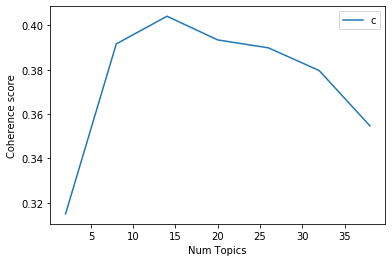

In [78]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [79]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3149
Num Topics = 8  has Coherence Value of 0.3917
Num Topics = 14  has Coherence Value of 0.4042
Num Topics = 20  has Coherence Value of 0.3935
Num Topics = 26  has Coherence Value of 0.3899
Num Topics = 32  has Coherence Value of 0.3797
Num Topics = 38  has Coherence Value of 0.3547


In [80]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(corpus, num_topics=14, id2word = id2word, passes=50)

In [150]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=doc_clean):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [151]:
doc_train = [doc.split() for doc in preprocessed_plot_train] 
doc_test = [doc.split() for doc in preprocessed_plot_test] 
doc_val = [doc.split() for doc in preprocessed_plot_val] 
corpus_train = [id2word.doc2bow(doc) for doc in doc_train]
corpus_test = [id2word.doc2bow(doc) for doc in doc_test]
corpus_val = [id2word.doc2bow(doc) for doc in doc_val]

In [152]:
df_topic_sents_keywords_train = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_train, texts=doc_train)
df_topic_sents_keywords_test = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_test, texts=doc_test)
df_topic_sents_keywords_val = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_val, texts=doc_val)

In [153]:
df_dominant_train = df_topic_sents_keywords_train.reset_index()
df_dominant_train.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [154]:
df_dominant_test = df_topic_sents_keywords_test.reset_index()
df_dominant_test.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [155]:
df_dominant_val = df_topic_sents_keywords_val.reset_index()
df_dominant_val.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [156]:
df_dominant_train.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.3599,"house, dr, body, room, finds, death, dead, fin...","[note, synopsis, orginal, italian, release, se..."
1,1,0.0,0.6108,"one, ship, two, find, back, escape, earth, cit...","[two, thousand, years, ago, nhagruul, foul, so..."
2,2,1.0,0.6169,"father, one, love, life, new, family, mother, ...","[glenn, holland, morning, person, anyone, stan..."
3,3,7.0,0.3619,"police, money, john, man, men, killed, kill, c...","[baise, moi, tells, story, nadine, manu, go, v..."
4,4,6.0,0.2462,"tells, back, says, asks, get, go, one, goes, s...","[kyle, pratt, jodie, foster, propulsion, engin..."
5,5,7.0,0.4542,"police, money, john, man, men, killed, kill, c...","[small, time, italian, american, criminals, ca..."
6,6,6.0,0.3554,"tells, back, says, asks, get, go, one, goes, s...","[movie, begins, video, shot, men, hands, tied,..."
7,7,1.0,0.5110,"father, one, love, life, new, family, mother, ...","[action, takes, place, years, sweden, troubled..."
8,8,9.0,0.5418,"house, dr, body, room, finds, death, dead, fin...","[somafree, institute, dr, hal, raglan, humilia..."
9,9,1.0,0.4668,"father, one, love, life, new, family, mother, ...","[brothers, terry, colin, farrell, ian, ewan, m..."


In [157]:
df_dominant_train['Keywords'] = df_dominant_train['Keywords'].apply(lambda x : x.split(','))

In [158]:
df_dominant_test['Keywords'] = df_dominant_test['Keywords'].apply(lambda x : x.split(','))
df_dominant_val['Keywords'] = df_dominant_val['Keywords'].apply(lambda x : x.split(','))

In [159]:
df_dominant_train.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.3599,"[house, dr, body, room, finds, death, de...","[note, synopsis, orginal, italian, release, se..."
1,1,0.0,0.6108,"[one, ship, two, find, back, escape, ear...","[two, thousand, years, ago, nhagruul, foul, so..."
2,2,1.0,0.6169,"[father, one, love, life, new, family, m...","[glenn, holland, morning, person, anyone, stan..."
3,3,7.0,0.3619,"[police, money, john, man, men, killed, ...","[baise, moi, tells, story, nadine, manu, go, v..."
4,4,6.0,0.2462,"[tells, back, says, asks, get, go, one, ...","[kyle, pratt, jodie, foster, propulsion, engin..."


In [160]:
df_dominant_val.shape

(2349, 5)

In [161]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_dominant_train['Keywords'])
labels = multilabel_binarizer.classes_

In [162]:
keywords_train = multilabel_binarizer.transform(df_dominant_train['Keywords'])
keywords_test = multilabel_binarizer.transform(df_dominant_test['Keywords'])
keywords_val = multilabel_binarizer.transform(df_dominant_val['Keywords'])

In [163]:
top_train_final = df_dominant_train[['Dominant_Topic','Topic_Perc_Contrib']]
top_test_final = df_dominant_test[['Dominant_Topic','Topic_Perc_Contrib']]
top_val_final = df_dominant_val[['Dominant_Topic','Topic_Perc_Contrib']]

In [164]:
temp_train = pd.DataFrame(keywords_train)
temp_test = pd.DataFrame(keywords_test)
temp_val = pd.DataFrame(keywords_val)

In [165]:
train_topic = pd.concat([top_train_final,temp_train], axis=1)
test_topic = pd.concat([top_test_final,temp_test], axis=1)
val_topic = pd.concat([top_val_final,temp_val], axis=1)

In [166]:
train_topic.head()

,Dominant_Topic,Topic_Perc_Contrib,0,1,2,3,4,5,6,7,...,123,124,125,126,127,128,129,130,131,132
0,9.0,0.3599,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0.6108,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,0.6169,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,7.0,0.3619,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6.0,0.2462,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## 3.5 Applying Logistic Regression with OneVsRest Classifier

In [56]:
alpha = [10**i for i in range(-8,-2)]

### Hyper parameter tuning using validation set

#### BOW

In [52]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1'))
    classifier.fit(final_counts_train, multilabel_train)
    predictions = classifier.predict(final_counts_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.021285653469561516
Hamming loss  0.05673975740351003
Micro-average quality numbers
Precision: 0.2368, Recall: 0.1495, F1-measure: 0.1833
Time taken to run this iteration : 0:00:11.397687
Alpha :  1e-07
Accuracy : 0.019582801191996593
Hamming loss  0.06188428998854772
Micro-average quality numbers
Precision: 0.2772, Recall: 0.2819, F1-measure: 0.2795
Time taken to run this iteration : 0:00:10.523084
Alpha :  1e-06
Accuracy : 0.022137079608343976
Hamming loss  0.05660185035286217
Micro-average quality numbers
Precision: 0.2753, Recall: 0.2016, F1-measure: 0.2328
Time taken to run this iteration : 0:00:10.544615
Alpha :  1e-05
Accuracy : 0.031502767134951044
Hamming loss  0.06481031784577194
Micro-average quality numbers
Precision: 0.2737, Recall: 0.3155, F1-measure: 0.2931
Time taken to run this iteration : 0:00:10.764515
Alpha :  0.0001
Accuracy : 0.02554278416347382
Hamming loss  0.06285563530180659
Micro-average quality numbers
Precision: 0.2866, Recall: 0.

In [57]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=i, penalty='l1'))
    classifier.fit(final_counts_train, multilabel_train)
    predictions = classifier.predict(final_counts_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.03065134099616858
Hamming loss  0.05483903848805905
Micro-average quality numbers
Precision: 0.3332, Recall: 0.2873, F1-measure: 0.3086
Time taken to run this iteration : 0:00:13.757347
Alpha :  1e-07
Accuracy : 0.016177096636866752
Hamming loss  0.06433064114786634
Micro-average quality numbers
Precision: 0.2324, Recall: 0.2216, F1-measure: 0.2269
Time taken to run this iteration : 0:00:12.004802
Alpha :  1e-06
Accuracy : 0.01319710515112814
Hamming loss  0.06434263306531397
Micro-average quality numbers
Precision: 0.2870, Recall: 0.3441, F1-measure: 0.3130
Time taken to run this iteration : 0:00:10.559572
Alpha :  1e-05
Accuracy : 0.025117071094082587
Hamming loss  0.058802367204504165
Micro-average quality numbers
Precision: 0.3125, Recall: 0.3173, F1-measure: 0.3149
Time taken to run this iteration : 0:00:10.691849
Alpha :  0.0001
Accuracy : 0.021285653469561516
Hamming loss  0.06419273409721847
Micro-average quality numbers
Precision: 0.2771, Recall: 0.

### TFIDF

In [53]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1'))
    classifier.fit(final_tf_idf_train, multilabel_train)
    predictions = classifier.predict(final_tf_idf_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.05491698595146871
Hamming loss  0.04926279687490631
Micro-average quality numbers
Precision: 0.3919, Recall: 0.2841, F1-measure: 0.3294
Time taken to run this iteration : 0:02:36.328119
Alpha :  1e-07
Accuracy : 0.06130268199233716
Hamming loss  0.04733209816583623
Micro-average quality numbers
Precision: 0.4132, Recall: 0.2651, F1-measure: 0.3230
Time taken to run this iteration : 0:02:38.020736
Alpha :  1e-06
Accuracy : 0.05236270753512133
Hamming loss  0.053891677009695466
Micro-average quality numbers
Precision: 0.3617, Recall: 0.3469, F1-measure: 0.3541
Time taken to run this iteration : 0:02:35.538647
Alpha :  1e-05
Accuracy : 0.05959982971477224
Hamming loss  0.04807559704758992
Micro-average quality numbers
Precision: 0.4170, Recall: 0.3237, F1-measure: 0.3645
Time taken to run this iteration : 0:02:38.583520
Alpha :  0.0001
Accuracy : 0.04469987228607918
Hamming loss  0.040364794128757216
Micro-average quality numbers
Precision: 0.6357, Recall: 0.12

In [58]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=i, penalty='l1'))
    classifier.fit(final_tf_idf_train, multilabel_train)
    predictions = classifier.predict(final_tf_idf_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.05874840357598978
Hamming loss  0.04718219919774072
Micro-average quality numbers
Precision: 0.4132, Recall: 0.2568, F1-measure: 0.3167
Time taken to run this iteration : 0:02:15.478095
Alpha :  1e-07
Accuracy : 0.05959982971477224
Hamming loss  0.04780577890501802
Micro-average quality numbers
Precision: 0.4064, Recall: 0.2658, F1-measure: 0.3214
Time taken to run this iteration : 0:02:10.630974
Alpha :  1e-06
Accuracy : 0.037888463175819495
Hamming loss  0.06079902145953627
Micro-average quality numbers
Precision: 0.3124, Recall: 0.3560, F1-measure: 0.3328
Time taken to run this iteration : 0:02:22.322338
Alpha :  1e-05
Accuracy : 0.04810557684120902
Hamming loss  0.05282439635685548
Micro-average quality numbers
Precision: 0.3656, Recall: 0.3269, F1-measure: 0.3452
Time taken to run this iteration : 0:02:17.246363
Alpha :  0.0001
Accuracy : 0.05321413367390379
Hamming loss  0.04008298406873767
Micro-average quality numbers
Precision: 0.6526, Recall: 0.125

In [56]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=10**-5, penalty='l1'))
classifier.fit(final_tf_idf_train, multilabel_train)
predictions = classifier.predict(final_tf_idf_test)

print("Alpha : ",i)
print("Accuracy :",metrics.accuracy_score(multilabel_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_test,predictions))


precision = precision_score(multilabel_test, predictions, average='micro')
recall = recall_score(multilabel_test, predictions, average='micro')
f1 = f1_score(multilabel_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  0.001
Accuracy : 0.0736196319018405
Hamming loss  0.04832128421517517
Micro-average quality numbers
Precision: 0.4164, Recall: 0.3138, F1-measure: 0.3579
Time taken to run this iteration : 0:02:30.344636


### AvgW2V

In [59]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1'))
    classifier.fit(sent_vectors_train, multilabel_train)
    predictions = classifier.predict(sent_vectors_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.008514261387824606
Hamming loss  0.06316742515544523
Micro-average quality numbers
Precision: 0.1823, Recall: 0.1387, F1-measure: 0.1575
Time taken to run this iteration : 0:00:02.211247
Alpha :  1e-07
Accuracy : 0.001277139208173691
Hamming loss  0.06624335198076496
Micro-average quality numbers
Precision: 0.1775, Recall: 0.1529, F1-measure: 0.1643
Time taken to run this iteration : 0:00:01.576534
Alpha :  1e-06
Accuracy : 0.01532567049808429
Hamming loss  0.056685793774995656
Micro-average quality numbers
Precision: 0.2537, Recall: 0.1705, F1-measure: 0.2039
Time taken to run this iteration : 0:00:01.629967
Alpha :  1e-05
Accuracy : 0.021711366538952746
Hamming loss  0.05650591501328105
Micro-average quality numbers
Precision: 0.3063, Recall: 0.2583, F1-measure: 0.2803
Time taken to run this iteration : 0:00:01.404570
Alpha :  0.0001
Accuracy : 0.05917411664538101
Hamming loss  0.046444696274710845
Micro-average quality numbers
Precision: 0.3989, Recall: 0

In [60]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=i, penalty='l1'))
    classifier.fit(sent_vectors_train, multilabel_train)
    predictions = classifier.predict(sent_vectors_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.0004257130693912303
Hamming loss  0.07325262772891071
Micro-average quality numbers
Precision: 0.1672, Recall: 0.1809, F1-measure: 0.1738
Time taken to run this iteration : 0:00:01.100667
Alpha :  1e-07
Accuracy : 0.020008514261387826
Hamming loss  0.05259055396662649
Micro-average quality numbers
Precision: 0.3110, Recall: 0.1932, F1-measure: 0.2383
Time taken to run this iteration : 0:00:01.107124
Alpha :  1e-06
Accuracy : 0.011494252873563218
Hamming loss  0.06214211621367199
Micro-average quality numbers
Precision: 0.2319, Recall: 0.1985, F1-measure: 0.2139
Time taken to run this iteration : 0:00:01.092320
Alpha :  1e-05
Accuracy : 0.005534269902085994
Hamming loss  0.062052176832814686
Micro-average quality numbers
Precision: 0.2537, Recall: 0.2354, F1-measure: 0.2442
Time taken to run this iteration : 0:00:01.073533
Alpha :  0.0001
Accuracy : 0.06555981268624947
Hamming loss  0.044268163257964135
Micro-average quality numbers
Precision: 0.4423, Recall:

### TFIDF W2V

In [138]:
alpha = [10**i for i in range(-10,0)]

In [61]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1'))
    classifier.fit(tfidf_sent_vectors_train, multilabel_train)
    predictions = classifier.predict(tfidf_sent_vectors_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-10
Accuracy : 0.01489995742869306
Hamming loss  0.055474610112783984
Micro-average quality numbers
Precision: 0.2078, Recall: 0.1076, F1-measure: 0.1417
Time taken to run this iteration : 0:00:01.238662
Alpha :  1e-09
Accuracy : 0.011919965942954448
Hamming loss  0.0613146739097848
Micro-average quality numbers
Precision: 0.2232, Recall: 0.1772, F1-measure: 0.1976
Time taken to run this iteration : 0:00:01.207359
Alpha :  1e-08
Accuracy : 0.005108556832694764
Hamming loss  0.06379700082144635
Micro-average quality numbers
Precision: 0.2593, Recall: 0.2682, F1-measure: 0.2637
Time taken to run this iteration : 0:00:01.346162
Alpha :  1e-07
Accuracy : 0.01277139208173691
Hamming loss  0.0626517727051967
Micro-average quality numbers
Precision: 0.2553, Recall: 0.2458, F1-measure: 0.2505
Time taken to run this iteration : 0:00:01.640881
Alpha :  1e-06
Accuracy : 0.008088548318433376
Hamming loss  0.06607546513649801
Micro-average quality numbers
Precision: 0.1906, Recall: 0.169

In [62]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=i, penalty='l1'))
    classifier.fit(tfidf_sent_vectors_train, multilabel_train)
    predictions = classifier.predict(tfidf_sent_vectors_cv)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-10
Accuracy : 0.0034057045551298426
Hamming loss  0.06374903315165578
Micro-average quality numbers
Precision: 0.1564, Recall: 0.1131, F1-measure: 0.1312
Time taken to run this iteration : 0:00:01.317739
Alpha :  1e-09
Accuracy : 0.011068539804171988
Hamming loss  0.06026538113311628
Micro-average quality numbers
Precision: 0.2868, Recall: 0.2792, F1-measure: 0.2829
Time taken to run this iteration : 0:00:01.160039
Alpha :  1e-08
Accuracy : 0.0034057045551298426
Hamming loss  0.07689217467426954
Micro-average quality numbers
Precision: 0.1973, Recall: 0.2626, F1-measure: 0.2253
Time taken to run this iteration : 0:00:01.176802
Alpha :  1e-07
Accuracy : 0.011494252873563218
Hamming loss  0.06365309781207466
Micro-average quality numbers
Precision: 0.2281, Recall: 0.2075, F1-measure: 0.2173
Time taken to run this iteration : 0:00:01.128806
Alpha :  1e-06
Accuracy : 0.005534269902085994
Hamming loss  0.06141060924936593
Micro-average quality numbers
Precision: 0.1601, Recall: 

### Topic Modelling

In [168]:
alpha = [10**i for i in range(-8,-2)]

In [169]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1'))
    classifier.fit(train_topic, multilabel_train)
    predictions = classifier.predict(val_topic)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.0021285653469561515
Hamming loss  0.06602749746670744
Micro-average quality numbers
Precision: 0.1923, Recall: 0.1719, F1-measure: 0.1815
Time taken to run this iteration : 0:00:03.184392
Alpha :  1e-07
Accuracy : 0.001277139208173691
Hamming loss  0.06066711036761223
Micro-average quality numbers
Precision: 0.1887, Recall: 0.1287, F1-measure: 0.1530
Time taken to run this iteration : 0:00:03.169143
Alpha :  1e-06
Accuracy : 0.010642826734780758
Hamming loss  0.08868022952529994
Micro-average quality numbers
Precision: 0.1549, Recall: 0.2429, F1-measure: 0.1891
Time taken to run this iteration : 0:00:03.281320
Alpha :  1e-05
Accuracy : 0.0
Hamming loss  0.07839116435522459
Micro-average quality numbers
Precision: 0.2009, Recall: 0.2823, F1-measure: 0.2347
Time taken to run this iteration : 0:00:03.353129
Alpha :  0.0001
Accuracy : 0.020008514261387826
Hamming loss  0.04338675732556257
Micro-average quality numbers
Precision: 0.4395, Recall: 0.0680, F1-measur

In [170]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=i, penalty='l1'))
    classifier.fit(train_topic, multilabel_train)
    predictions = classifier.predict(val_topic)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.0004257130693912303
Hamming loss  0.06835392945154965
Micro-average quality numbers
Precision: 0.2125, Recall: 0.2236, F1-measure: 0.2179
Time taken to run this iteration : 0:00:02.793741
Alpha :  1e-07
Accuracy : 0.0008514261387824606
Hamming loss  0.06379700082144635
Micro-average quality numbers
Precision: 0.1799, Recall: 0.1399, F1-measure: 0.1574
Time taken to run this iteration : 0:00:02.711463
Alpha :  1e-06
Accuracy : 0.01362281822051937
Hamming loss  0.055030909167221295
Micro-average quality numbers
Precision: 0.2864, Recall: 0.1958, F1-measure: 0.2326
Time taken to run this iteration : 0:00:02.698790
Alpha :  1e-05
Accuracy : 0.005534269902085994
Hamming loss  0.0672386811289191
Micro-average quality numbers
Precision: 0.1571, Recall: 0.1326, F1-measure: 0.1438
Time taken to run this iteration : 0:00:02.756970
Alpha :  0.0001
Accuracy : 0.03065134099616858
Hamming loss  0.05235071561767369
Micro-average quality numbers
Precision: 0.2431, Recall: 0

### Deep learning for feature extraction

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train_set['plot_synopsis'])
sequences = tokenizer.texts_to_sequences(train_set['plot_synopsis'])
x_train = pad_sequences(sequences, maxlen=7000)

Using TensorFlow backend.


In [32]:
sequences = tokenizer.texts_to_sequences(test_set['plot_synopsis'])
x_test = pad_sequences(sequences, maxlen=7000)

In [33]:
sequences = tokenizer.texts_to_sequences(val_set['plot_synopsis'])
x_val = pad_sequences(sequences, maxlen=7000)

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(5000, 20, input_length=7000))
model.add(Dropout(0.15))
model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(71, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-simple.h5', save_best_only=True)
]

history = model.fit(x_train, multilabel_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(x_val, multilable_val),
                    callbacks=callbacks)

Train on 9203 samples, validate on 2349 samples
Epoch 1/30
9203/9203 [==============================] - 202s 22ms/step - loss: 0.1904 - categorical_accuracy: 0.1334 - val_loss: 0.1429 - val_categorical_accuracy: 0.1528
Epoch 2/30
9203/9203 [==============================] - 200s 22ms/step - loss: 0.1398 - categorical_accuracy: 0.1426 - val_loss: 0.1419 - val_categorical_accuracy: 0.1626
Epoch 3/30
9203/9203 [==============================] - 202s 22ms/step - loss: 0.1367 - categorical_accuracy: 0.1523 - val_loss: 0.1408 - val_categorical_accuracy: 0.1716
Epoch 4/30
9203/9203 [==============================] - 202s 22ms/step - loss: 0.1333 - categorical_accuracy: 0.1576 - val_loss: 0.1393 - val_categorical_accuracy: 0.1626
Epoch 5/30
9203/9203 [==============================] - 202s 22ms/step - loss: 0.1319 - categorical_accuracy: 0.1664 - val_loss: 0.1355 - val_categorical_accuracy: 0.1733
Epoch 6/30
9203/9203 [==============================] - 202s 22ms/step - loss: 0.1305 - categoric

In [41]:
import keras
cnn_model = keras.models.load_model('model-simple.h5')
metrics = cnn_model.evaluate(x_test, multilabel_test)

2934/2934 [==============================] - 15s 5ms/step


In [42]:
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

loss: 0.1323340391840509
categorical_accuracy: 0.20177232452249885


# Conclusion

In [70]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter (Alpha)", "Precision", "Recall", "F1 Score"]
x.add_row(["BOW", "LogisticRegression", 10**-4, 0.2868, 0.3196, 0.3022])
x.add_row(["BOW", "LinearSVM", 10**-5, 0.3125, 0.3173, 0.3149])
x.add_row(["AvgW2V", "LogisticRegression", 10**-5, 0.3063, 0.2583, 0.2803])
x.add_row(["AvgW2V", "LinearSVM", 10**-5, 0.2537, 0.2354, 0.2442])
x.add_row(["TFIDF W2V", "LogisticRegression", 10**-8, 0.2593, 0.2682, 0.2637])
x.add_row(["TFIDF W2V", "LinearSVM", 10**-9, 0.2868, 0.2792, 0.2829])
x.add_row(["TFIDF ngram(1,4)", "LogisticRegression", 10**-5, 0.4170, 0.3237, 0.3645])
x.add_row(["TFIDF ngram(1,4)", "LinearSVM", 10**-5, 0.3656, 0.3269, 0.3452])

print(x)

+------------------+--------------------+-------------------------+-----------+--------+----------+
|    Vectorizer    |       Model        | Hyper parameter (Alpha) | Precision | Recall | F1 Score |
+------------------+--------------------+-------------------------+-----------+--------+----------+
|       BOW        | LogisticRegression |          0.0001         |   0.2868  | 0.3196 |  0.3022  |
|       BOW        |     LinearSVM      |          1e-05          |   0.3125  | 0.3173 |  0.3149  |
|      AvgW2V      | LogisticRegression |          1e-05          |   0.3063  | 0.2583 |  0.2803  |
|      AvgW2V      |     LinearSVM      |          1e-05          |   0.2537  | 0.2354 |  0.2442  |
|    TFIDF W2V     | LogisticRegression |          1e-08          |   0.2593  | 0.2682 |  0.2637  |
|    TFIDF W2V     |     LinearSVM      |          1e-09          |   0.2868  | 0.2792 |  0.2829  |
| TFIDF ngram(1,4) | LogisticRegression |          1e-05          |   0.417   | 0.3237 |  0.3645  |


In [173]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter (Alpha)", "Precision", "Recall", "F1 Score"]
x.add_row(["Topic Modelling", "LogisticRegression", 10**-5, 0.2009, 0.2823, 0.2347])
x.add_row(["Topic Modelling", "LinearSVM", 10**-6, 0.2864, 0.1958, 0.2326])
print(x)

+-----------------+--------------------+-------------------------+-----------+--------+----------+
|    Vectorizer   |       Model        | Hyper parameter (Alpha) | Precision | Recall | F1 Score |
+-----------------+--------------------+-------------------------+-----------+--------+----------+
| Topic Modelling | LogisticRegression |          1e-05          |   0.2009  | 0.2823 |  0.2347  |
| Topic Modelling |     LinearSVM      |          1e-06          |   0.2864  | 0.1958 |  0.2326  |
+-----------------+--------------------+-------------------------+-----------+--------+----------+


In [174]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "Epochs", "F1 Score"]
x.add_row(["Convo1D", 30, 0.2017])
print(x)

+---------+--------+----------+
|  Model  | Epochs | F1 Score |
+---------+--------+----------+
| Convo1D |   30   |  0.2017  |
+---------+--------+----------+


In [175]:
print('BEST MODEL')
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter (Alpha)", "Precision", "Recall", "F1 Score"]
x.add_row(["TFIDF ngram(1,4)", "LogisticRegression", 10**-5, 0.4164, 0.313, 0.3579])
print(x)

BEST MODEL
+------------------+--------------------+-------------------------+-----------+--------+----------+
|    Vectorizer    |       Model        | Hyper parameter (Alpha) | Precision | Recall | F1 Score |
+------------------+--------------------+-------------------------+-----------+--------+----------+
| TFIDF ngram(1,4) | LogisticRegression |          1e-05          |   0.4164  | 0.313  |  0.3579  |
+------------------+--------------------+-------------------------+-----------+--------+----------+


#### Steps followed in Case Study

- ____Step 1____ : Analyze data and determine features that can be built using the dataset.
- ____Step 2____ : In this case study BOW, TFIDF, AvgW2V, TFIDF-W2V, LDA(Topic Modelling) is used for feature extraction.
- ____Step 3____ : Split data into Test,val and Train data. 
- ____Step 4____ : Fit train data on each feature and extract corresponding values on test and val data.
- ____Step 5____ : Apply Logistic Regression.
- ____Step 6____ : Find the corresponding Micro F1 score in each case.
- ____Step 7____ : The best model is determined with one having the most F1 score.

- ____Observations____ : In the following case study, Logistic Regression shows better scores with precision of 0.42, recall of 0.33 and F1 score of 0.36.